In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import librosa
import math
import time

sys.path.append('vqvae')
from utils import inv_mu_law_numpy
from model import *

import IPython
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/.pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
sample_rate = 8000  # Hz
SAMPLE_DURATION = 0.32
sample_period = 1.0/sample_rate
times = np.arange(0.0, SAMPLE_DURATION, sample_period)
sample_size = int(sample_rate * SAMPLE_DURATION)

def make_base_sine_wav(F0):
    return np.sin(times * 2.0 * np.pi * F0)

def make_sine_waves(speaker_id):
    speaker_tone = np.random.randint(100*speaker_id, high=300*speaker_id)
    
    amplitudes = make_base_sine_wav(speaker_tone)
    
    if speaker_id == 1: 
        return amplitudes
    
    if speaker_id == 2:
        low, high = 40, 80
        n = 2
        sin_func = np.sin
    elif speaker_id == 3:
        low, high = 400, 800
        n = 8        
        sin_func = np.cos
        
    for i in range(n):
        F0 = np.random.randint(low, high=high)
        amplitudes += (sin_func(times * 2.0 * np.pi * F0))

    amplitudes /= n

    return amplitudes

In [31]:
speaker_size = 3
batch_size = 3
train_data_size = speaker_size * 10
test_data_size = 3
train_ids = [(i % speaker_size + 1) for i in range(train_data_size)]
train_data = [make_sine_waves(id) for id in train_ids]
test_ids = [(i % speaker_size + 1) for i in range(speaker_size * test_data_size)]
test_data = [make_sine_waves(id) for id in test_ids]

In [32]:
class BatchLoader:
    def __init__(self, batch_size, data, ids, shuffle=False):
        self.batch_size = batch_size
        self.data = data
        self.n_data = len(data)
        self.ids = np.array(ids)
        
        if shuffle:
            random_indices = np.random.permutation(self.n_data)
            self.data = self.data[random_indices]
            self.ids = self.ids[random_indices]
        
        self.idx = 0
        self.step_per_epoch = int(math.ceil(float(self.n_data)/self.batch_size))
    
    def get_epoch_step(self, epoch):
        return self.step_per_epoch * epoch
    
    def load(self):
        fr = self.idx
        to = self.idx + self.batch_size

        if to > self.n_data:
            self.idx = to % self.n_data
            n_remains = to - self.n_data
            to = self.n_data
        else:
            n_remains = 0
            self.idx = to
            
        data = self.data[fr:to]
        ids = self.ids[fr:to]
        if n_remains > 0:
            data = np.concatenate((data, self.data[:n_remains])) 
            ids = np.concatenate((ids, self.ids[:n_remains])) 
        
        return data, ids

In [33]:
wavdir = os.path.expanduser('./logs/temp_test')
if not os.path.exists(wavdir):
    os.makedirs(wavdir)   

In [39]:
tf.reset_default_graph()
net = VQVAE(batch_size=batch_size, sample_size=sample_size, is_training=True, K=128,
            lr=0.001, use_gc=True, gc_cardinality=speaker_size+1, n_stack=3, max_dilation=10,
            residual_channels=64, dilation_channels=64, skip_channels=128, use_biases=False, 
            upsampling_method='deconv')

padded_audio = tf.placeholder(dtype=tf.float32)
gc_batch = tf.placeholder(dtype=tf.int32)
raw_output = net.create_model(padded_audio, gc_batch)
loss, recon_loss = net.loss(raw_output)

In [40]:
step_per_log = 300
step_per_valid = 2000
step_per_save = 2000
n_epoch = 1000000
max_keep = 10

# with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 
        
    _data = np.vstack(train_data).astype(np.float32)
    _data = _data.reshape(train_data_size, sample_size, 1)
    batchloader = BatchLoader(batch_size, _data, train_ids)

    _test_data = np.vstack(test_data).astype(np.float32)
    _test_data = _test_data.reshape(len(test_data), sample_size, 1)
    test_batchloader = BatchLoader(batch_size, _test_data, test_ids)
    
    avg_loss = 0
    last_avg_loss = 9999
    t = time.time()
    for step in range(1, batchloader.get_epoch_step(n_epoch)):
        mini_batch, mini_ids = batchloader.load()
        padded_mini_batch = np.pad(mini_batch, ((0, 0), (net.receptive_field - 1, 0), (0, 0)),'constant')        
      
        _loss, _target, a_lc, a_gc, _ = sess.run([recon_loss, net.encoded_input, net.lc, net.gc, net.train_op], 
                                    feed_dict={padded_audio:padded_mini_batch, gc_batch:mini_ids})
        
        avg_loss += _loss

        if step > 0 and (step % step_per_log) == 0:
            avg_loss /= step_per_log
            c_t = time.time()
            print(step, 'avg loss: {}, elapsed: {:.2f}'.format(avg_loss, c_t-t))
            t = c_t
            last_avg_loss = avg_loss
            avg_loss = 0
            
        if step > 0 and (step % step_per_save) == 0:
            net.save(sess, wavdir, step)               
        
        if last_avg_loss < 1e-2 and step > 0 and (step % step_per_valid) == 0:
#         if step > 0 and (step % step_per_valid) == 0:
            labels = tf.placeholder(tf.float32)
            generated = tf.placeholder(tf.float32)
            gen_loss = -tf.reduce_mean(labels * tf.log(generated + 1e-4))


            seed_sample = np.argmax(_target[:, 0, :], axis=1).reshape(-1, 1)

            waveform, softmax_result = net.generate_waveform(sess, sample_size, a_lc, a_gc, 
                                                seed=seed_sample, use_randomness=False)
            
            _gen_loss  = sess.run(gen_loss, feed_dict={generated:softmax_result[:, 1:, :], labels:_target})
            print('\tgen_loss:', _gen_loss)

            gen_wav = inv_mu_law_numpy(waveform, quantization_channels=net.quantization_channels)
            gen_wav = np.reshape(gen_wav, [batch_size, -1])           
            
            for k in range(batch_size):
                fname = os.path.join(wavdir, str(step) + '-' + str(k) + '.wav')
                librosa.output.write_wav(fname, gen_wav[k,:], sample_rate)

                rm_number = step - max_keep * step_per_valid
                if rm_number > 0:
                    rm_fname = os.path.join(wavdir, str(rm_number) + '-' + str(k) + '.wav')
                    if os.path.exists(rm_fname):
                        os.remove(rm_fname)
            
            break

300 avg loss: 2.8429432197411857, elapsed: 163.07
600 avg loss: 1.752590389251709, elapsed: 160.96
900 avg loss: 1.301096821029981, elapsed: 160.95
1200 avg loss: 0.8743641998370488, elapsed: 161.01
1500 avg loss: 0.8844521432121595, elapsed: 160.98
1800 avg loss: 0.2846370292703311, elapsed: 160.95
Storing checkpoint to ./logs/temp_test ... Done.
2100 avg loss: 0.5151818617743751, elapsed: 163.29
2400 avg loss: 0.022915264489129186, elapsed: 160.97
2700 avg loss: 0.011222886350005866, elapsed: 160.99
3000 avg loss: 0.0070220922927061715, elapsed: 160.98
3300 avg loss: 0.004954194354359061, elapsed: 160.94
3600 avg loss: 0.0037648505911541483, elapsed: 160.93
3900 avg loss: 0.003027624641545117, elapsed: 160.96
Storing checkpoint to ./logs/temp_test ... Done.
	gen_loss: 0.033584


In [60]:
def plot(wav, title=None):
    plt.figure(figsize=(10,5))
    if title is not None:
        plt.title(title)
    plt.plot(wav)
    plt.show()      

def convert(batch_id, use_randomness=False):
    _test_data = np.vstack(test_data).astype(np.float32)
    _test_data = _test_data.reshape(len(test_data), sample_size)
    
    fr = batch_id * batch_size
    to = fr + batch_size
    src = _test_data[fr:to, :]
    for i in range(batch_size):
        _src = src[i, :]
        IPython.display.display(Audio(_src, rate=sample_rate))
        plot(_src[:sample_size//2], "Source(Type-{})".format(i+1))
    
    src_ids = np.arange(1, speaker_size+1)
    for target_id in range(1, speaker_size+1):
        wavs = vc.convert([target_id] * batch_size, src=src, use_randomness=use_randomness)
        print(wavs.shape)
        for i, wav in enumerate(wavs):
            title = "Converted from source(Type-{}) to Type-{}".format(src_ids[i], target_id)
            IPython.display.display(Audio(wav, rate=sample_rate))        
            plot(wav[:sample_size//2], title)

In [61]:
tf.reset_default_graph()

net = VQVAE(batch_size=batch_size, sample_size=sample_size, is_training=True, K=128,
            lr=0.001, use_gc=True, gc_cardinality=speaker_size+1, n_stack=3, max_dilation=10,
            residual_channels=64, dilation_channels=64, skip_channels=128, use_biases=False, 
            upsampling_method='deconv')

checkpoint_path = os.path.join('./logs/temp_test', 'model.ckpt-4000')

vc = VoiceConverter(net, checkpoint_path, batch_size=batch_size, 
                    sample_rate=sample_rate, sample_size=sample_size, 
                    session_config=tf.ConfigProto(device_count={'GPU': 0}))

Loading checkpoint: ./logs/temp_test/model.ckpt-4000
INFO:tensorflow:Restoring parameters from ./logs/temp_test/model.ckpt-4000


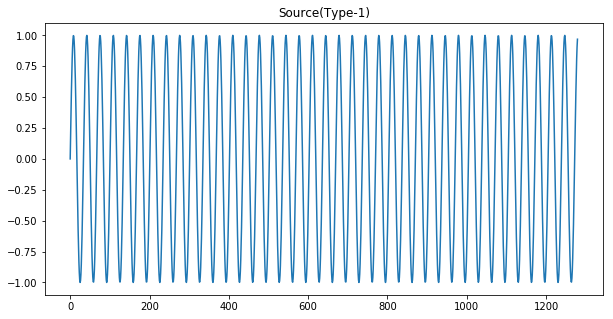

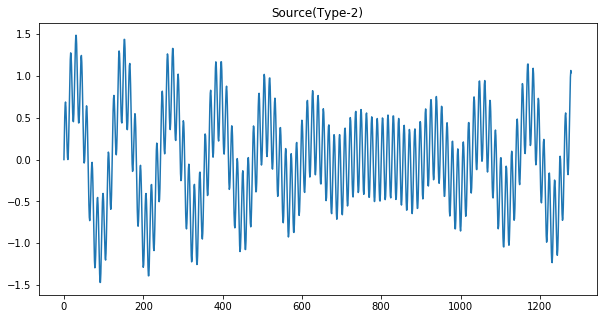

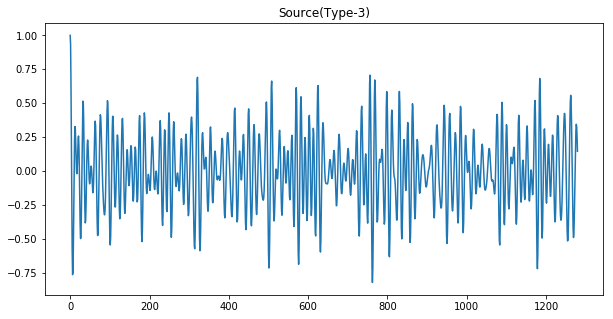

(3, 2559)


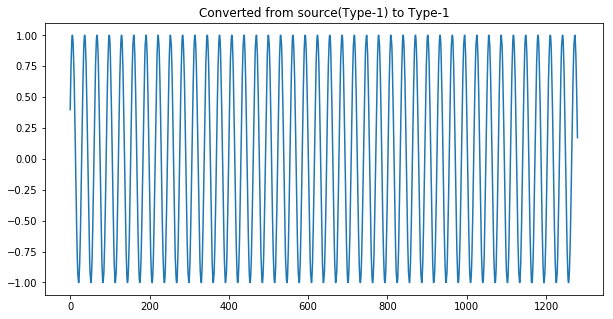

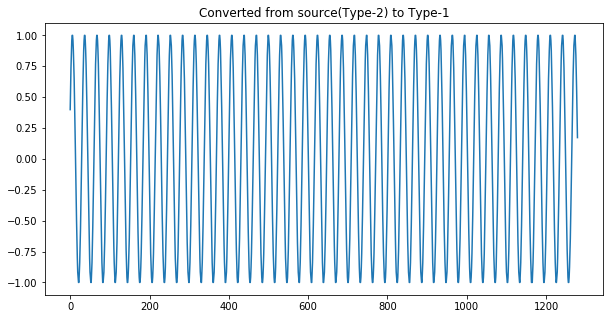

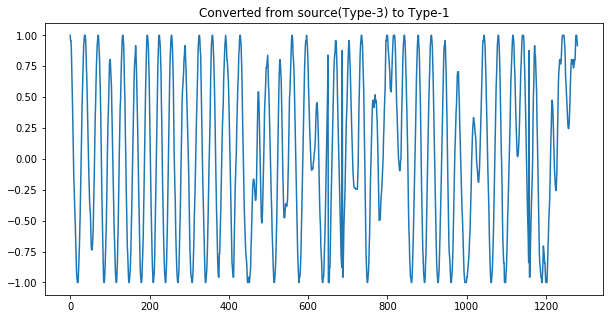

(3, 2559)


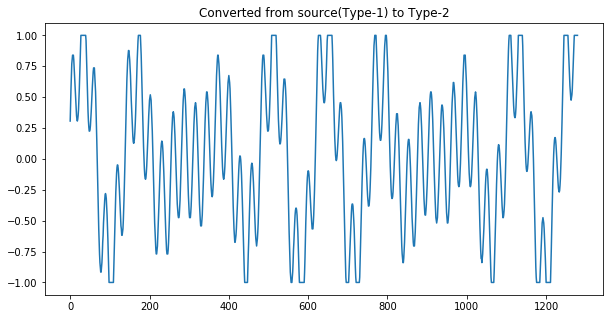

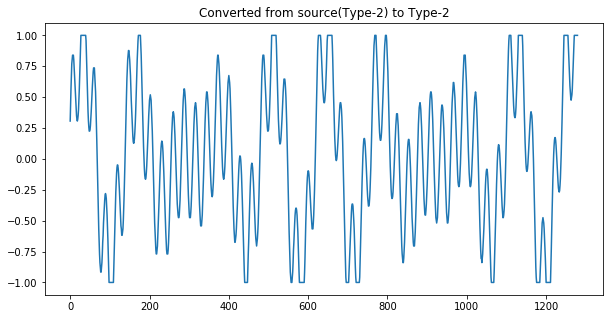

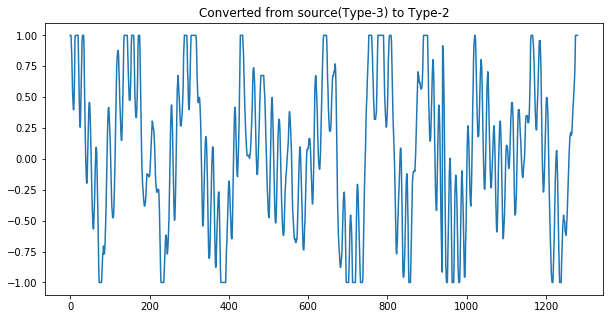

(3, 2559)


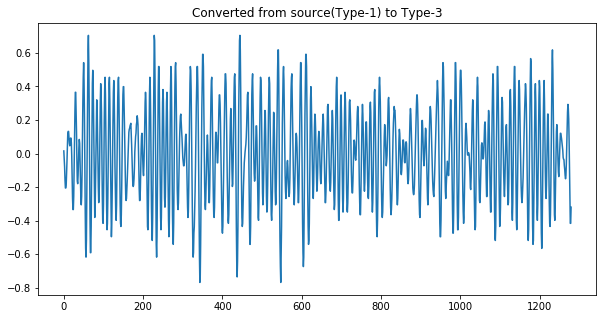

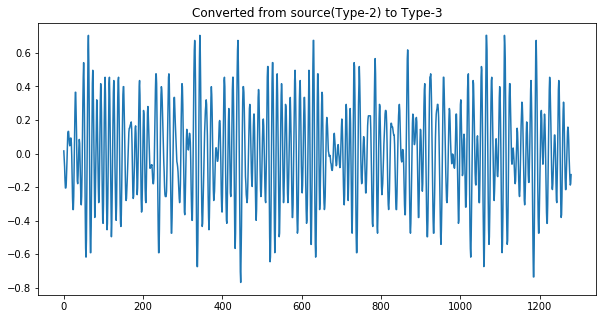

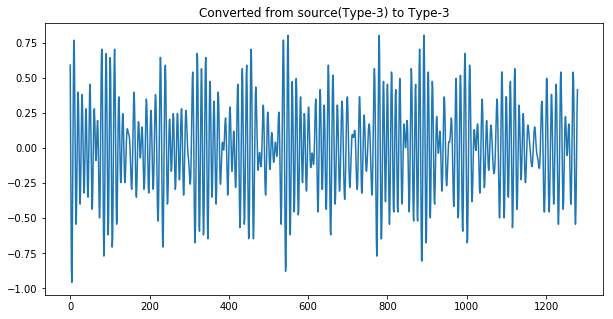

In [62]:
convert(0)